In [ ]:
# Install cell, Install if needed

#pip install sklearn
#pip install Keras-Preprocessing

In [1]:
import tensorflow as tf
tf.test.is_built_with_cuda()

True

In [1]:
#import block

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import matplotlib.pyplot as plt
from keras_flops import get_flops
import pandas as pd
#ResNet Resource
#https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b
import tensorflow.keras as K

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import os
from PIL import Image
from skimage import io

from keras.models import Model
import keras
tf.enable_v2_behavior()

In [2]:
#Variable block
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 25
LEARNING_RATE_TEACHER = 0.0001
LEARNING_RATE_STUDENT_KD = 0.001
LEARNING_RATE_STUDENT_SC = 0.001

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import tensorflow.python.keras.backend as KTF

os.environ["CUDA_VISIBLE_DEVICES"]="0" 
config = tf.compat.v1.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9 #90% GPU-MEM
config.gpu_options.allow_growth=True
session = tf.compat.v1.Session(config=config)

# setup session
KTF.set_session(session)

# Load Data

In [5]:
#load data use panda

#read annotation file
annotations = pd.read_csv("./annotations.csv", skiprows = 1,
                         names = ["Image Name","Majority Vote Label","Number of Annotations who Selected SSA(Out of 7)","Partition"])
annotations.head()

#Create dataframe
df = pd.DataFrame(annotations,
                 columns = ["Image Name","Majority Vote Label","Number of Annotations who Selected SSA(Out of 7)", "Partition"])
df.set_index("Image Name",inplace = True)

df.head()

,Majority Vote Label,Number of Annotations who Selected SSA(Out of 7),Partition
Image Name,,,
MHIST_aaa.png,SSA,6,train
MHIST_aab.png,HP,0,train
MHIST_aac.png,SSA,5,train
MHIST_aae.png,HP,1,train
MHIST_aaf.png,SSA,5,train


# Data Augmentation

In [6]:
#resource: https://www.youtube.com/watch?v=ccdssX4rIh8
SIZE = 224
image_directory = "images/"

datagen = ImageDataGenerator(
    rotation_range = 180,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.5,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

all_images = os.listdir(image_directory)

#read test images and process them
test_images = []
test_labels = []
for i, image_name in enumerate(all_images):
    if df.loc[image_name][2] == 'test':
        #load test image and label
        image = io.imread(image_directory+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE,SIZE))
        image_array = np.array(image)
        test_images.append(image_array)
        test_labels.append(df.loc[image_name][0])
        image_array = image_array.reshape((1,)+image_array.shape)
        #data augmentation
        #image_array = expand_dims(image_array,0)
        iterator = datagen.flow(image_array,batch_size = 1)
        for i in range(1,2):
            batch = iterator.next()
            image = batch[0].astype('uint8')
            test_images.append(image)
            test_labels.append(df.loc[image_name][0])
            
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print("Test Image Shape: {}".format(test_images.shape))
print("Test Image label: {}".format(test_labels.shape))

#read train images and process them
train_images = []
train_labels = []
for i, image_name in enumerate(all_images):
    if df.loc[image_name][2] == 'train':
        image = io.imread(image_directory+image_name)
        image = Image.fromarray(image,'RGB')
        image = image.resize((SIZE,SIZE))
        image_array = np.array(image)
        train_images.append(image_array)
        train_labels.append(df.loc[image_name][0])
        image_array = image_array.reshape((1,)+image_array.shape)
        iterator = datagen.flow(image_array,batch_size = 1)
        for i in range(1,3):
            batch = iterator.next()
            image = batch[0].astype('uint8')
            train_images.append(image)
            train_labels.append(df.loc[image_name][0])
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print("Train Image Shape: {}".format(train_images.shape))
print("Train Label Shape: {}".format(train_labels.shape))

Test Image Shape: (1954, 224, 224, 3)
Test Image label: (1954,)
Train Image Shape: (6525, 224, 224, 3)
Train Label Shape: (6525,)


In [7]:
#normalize the test images and train images
train_images_normalized = train_images.astype('float32')/255.0
test_images_normalized = test_images.astype('float32')/255.0

#encode the labels
encoder = LabelEncoder()
encoder.fit(train_labels)
train_labels_encoded = encoder.transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

# Create Model

In [8]:
#teacher model

def teacher_model():
    res_model = K.applications.resnet_v2.ResNet50V2(include_top = False, weights="imagenet",input_shape=(224,224,3))
    for layer in res_model.layers:
        layer.trainable = False
    x = K.layers.Flatten()(res_model.output)
    outputs = K.layers.Dense(2,activation="softmax")(x) 
    teacher = Model(inputs = res_model.input, outputs = outputs)
    return teacher

#student model
def student_model():
    mob_model = K.applications.mobilenet_v2.MobileNetV2(include_top = False, weights="imagenet", input_shape=(224,224,3))
    for layer in mob_model.layers:
        layer.trainable = False
    x = K.layers.Flatten()(mob_model.output)
    outputs = K.layers.Dense(2, activation = "softmax")(x)
    student = Model(inputs = mob_model.input, outputs = outputs)
    return student

In [12]:
class Distiller(Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=4,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        # return results
        return y_prediction

# Model Train

## Fine Tuning

In [9]:
#Train teacher
teacher = teacher_model()

teacher.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_TEACHER),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
teacher.fit(train_images_normalized, train_labels_encoded, epochs = FINE_TUNE_EPOCHS)

Epoch 1/25
204/204 [==============================] - 21s 70ms/step - loss: 0.7623 - sparse_categorical_accuracy: 0.7367
Epoch 2/25
204/204 [==============================] - 14s 67ms/step - loss: 0.2650 - sparse_categorical_accuracy: 0.8926
Epoch 3/25
204/204 [==============================] - 14s 67ms/step - loss: 0.1092 - sparse_categorical_accuracy: 0.9621
Epoch 4/25
204/204 [==============================] - 14s 70ms/step - loss: 0.0556 - sparse_categorical_accuracy: 0.9900
Epoch 5/25
204/204 [==============================] - 14s 68ms/step - loss: 0.0290 - sparse_categorical_accuracy: 0.9991
Epoch 6/25
204/204 [==============================] - 14s 68ms/step - loss: 0.0199 - sparse_categorical_accuracy: 1.0000
Epoch 7/25
204/204 [==============================] - 14s 67ms/step - loss: 0.0153 - sparse_categorical_accuracy: 1.0000
Epoch 8/25
204/204 [==============================] - 14s 68ms/step - loss: 0.0119 - sparse_categorical_accuracy: 1.0000
Epoch 9/25
204/204 [============

In [10]:
y_pred = teacher.predict(test_images_normalized)
y_pred = np.rint(y_pred)
result = np.argmax(y_pred,axis = 1)
f1_score_result = metrics.f1_score(test_labels_encoded,result)
auc_score_result = metrics.roc_auc_score(test_labels_encoded, result)
print("Teacher Model Fine Tune f1 score: {}".format(f1_score_result))
print("Teacher Model Fine Tune AUC score: {}".format(auc_score_result))

62/62 [==============================] - 5s 71ms/step
Teacher Model Fine Tune f1 score: 0.665648854961832
Teacher Model Fine Tune AUC score: 0.7403790743742122


In [14]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it does something you should see a number as output

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [27]:
reset_keras()

110


In [19]:
#First Tune T
Ts = [1,2,4,16,32,64]
student_models = []
for T in Ts:
    student = student_model()
    student_models.append(student)
    distiller = Distiller(student = student,teacher = teacher)
    distiller.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_STUDENT_KD),
        metrics = [keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn = keras.losses.SparseCategoricalCrossentropy(),
        distillation_loss_fn = keras.losses.KLDivergence(),
        alpha = 0.5,
        temperature = T
    )
    distiller.fit(train_images_normalized,train_labels_encoded,epochs = FINE_TUNE_EPOCHS)
    reset_keras()

Epoch 1/25
204/204 [==============================] - 23s 97ms/step - sparse_categorical_accuracy: 0.7316 - student_loss: 3.1078 - distillation_loss: 0.1150
Epoch 2/25
204/204 [==============================] - 20s 97ms/step - sparse_categorical_accuracy: 0.8520 - student_loss: 1.1621 - distillation_loss: 0.0615
Epoch 3/25
204/204 [==============================] - 20s 97ms/step - sparse_categorical_accuracy: 0.8981 - student_loss: 0.8152 - distillation_loss: 0.0427
Epoch 4/25
204/204 [==============================] - 20s 97ms/step - sparse_categorical_accuracy: 0.9295 - student_loss: 0.4891 - distillation_loss: 0.0288
Epoch 5/25
204/204 [==============================] - 20s 97ms/step - sparse_categorical_accuracy: 0.9494 - student_loss: 0.3150 - distillation_loss: 0.0205
Epoch 6/25
204/204 [==============================] - 20s 97ms/step - sparse_categorical_accuracy: 0.9574 - student_loss: 0.2779 - distillation_loss: 0.0174
Epoch 7/25
204/204 [==============================] - 20s 

204/204 [==============================] - 19s 93ms/step - sparse_categorical_accuracy: 0.8616 - student_loss: 1.1762 - distillation_loss: 0.0039
Epoch 3/25
204/204 [==============================] - 19s 93ms/step - sparse_categorical_accuracy: 0.9100 - student_loss: 0.6181 - distillation_loss: 0.0025
Epoch 4/25
204/204 [==============================] - 19s 93ms/step - sparse_categorical_accuracy: 0.9318 - student_loss: 0.5024 - distillation_loss: 0.0019
Epoch 5/25
204/204 [==============================] - 19s 93ms/step - sparse_categorical_accuracy: 0.9510 - student_loss: 0.3171 - distillation_loss: 0.0013
Epoch 6/25
204/204 [==============================] - 19s 92ms/step - sparse_categorical_accuracy: 0.9657 - student_loss: 0.2096 - distillation_loss: 9.1173e-04
Epoch 7/25
204/204 [==============================] - 19s 93ms/step - sparse_categorical_accuracy: 0.9510 - student_loss: 0.3510 - distillation_loss: 0.0014
Epoch 8/25
204/204 [==============================] - 19s 93ms/st

204/204 [==============================] - 20s 98ms/step - sparse_categorical_accuracy: 0.8544 - student_loss: 1.1808 - distillation_loss: 6.4027e-05
Epoch 3/25
204/204 [==============================] - 20s 98ms/step - sparse_categorical_accuracy: 0.9004 - student_loss: 0.8215 - distillation_loss: 4.4456e-05
Epoch 4/25
204/204 [==============================] - 20s 98ms/step - sparse_categorical_accuracy: 0.9362 - student_loss: 0.3891 - distillation_loss: 2.7736e-05
Epoch 5/25
204/204 [==============================] - 20s 98ms/step - sparse_categorical_accuracy: 0.9487 - student_loss: 0.3144 - distillation_loss: 2.2244e-05
Epoch 6/25
204/204 [==============================] - 20s 98ms/step - sparse_categorical_accuracy: 0.9621 - student_loss: 0.2394 - distillation_loss: 1.6400e-05
Epoch 7/25
204/204 [==============================] - 20s 98ms/step - sparse_categorical_accuracy: 0.9683 - student_loss: 0.1836 - distillation_loss: 1.3207e-05
Epoch 8/25
204/204 [=========================

In [30]:
student_f1_results = []
student_auc_results = []
for model in student_models:
    y_pred = model.predict(test_images_normalized)
    y_pred = np.rint(y_pred)
    result = np.argmax(y_pred, axis=1)
    f1_score_result = metrics.f1_score(test_labels_encoded,result)
    auc_score_result = metrics.roc_auc_score(test_labels_encoded,result)
    student_f1_results.append(f1_score_result)
    student_auc_results.append(auc_score_result)
    reset_keras()

62/62 [==============================] - 2s 24ms/step
807
62/62 [==============================] - 2s 25ms/step
801
62/62 [==============================] - 2s 25ms/step
801
62/62 [==============================] - 2s 25ms/step
801
62/62 [==============================] - 2s 25ms/step
801
62/62 [==============================] - 2s 25ms/step
801


In [31]:
print(student_f1_results)
print(student_auc_results)

[0.5612244897959183, 0.6118935837245696, 0.6452054794520549, 0.5836768342951361, 0.5918203688853247, 0.6090909090909091]
[0.6781131820637493, 0.7038616513596255, 0.7180881955699622, 0.6895124257158293, 0.6922305510534845, 0.6989397622906537]


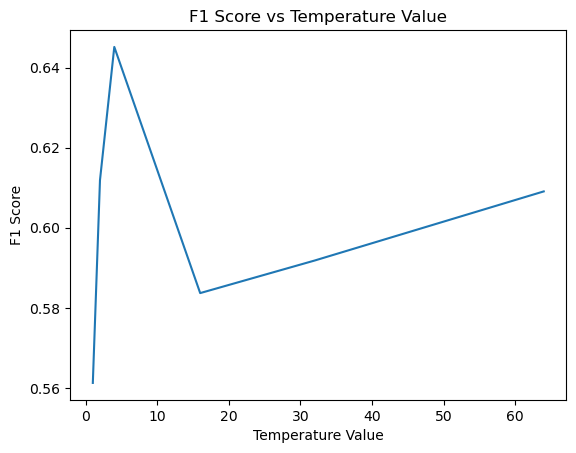

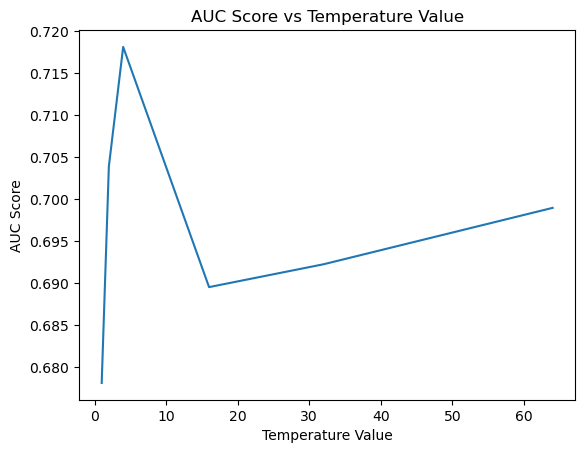

In [36]:
#plot the result vs Temperature
plt.plot(Ts,student_f1_results,label = "F1 Scores")
plt.xlabel("Temperature Value")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Temperature Value")
plt.show()
plt.plot(Ts,student_auc_results, label = "AUC Scores")
plt.xlabel("Temperature Value")
plt.ylabel("AUC Score")
plt.title("AUC Score vs Temperature Value")
plt.show()

## Train and Compare

In [55]:
# teacher model
teacher = teacher_model()

#student model
student = student_model()

#Initial Train teacher model, the alpha and temperature will be tuned
teacher.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_TEACHER),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

teacher.fit(train_images_normalized, train_labels_encoded, epochs= INITIAL_EPOCHS)

Epoch 1/10
204/204 [==============================] - 162s 784ms/step - loss: 0.7632 - sparse_categorical_accuracy: 0.7398
Epoch 2/10
204/204 [==============================] - 162s 793ms/step - loss: 0.2778 - sparse_categorical_accuracy: 0.8838
Epoch 3/10
204/204 [==============================] - 161s 788ms/step - loss: 0.1254 - sparse_categorical_accuracy: 0.9559
Epoch 4/10
204/204 [==============================] - 161s 789ms/step - loss: 0.0606 - sparse_categorical_accuracy: 0.9873
Epoch 5/10
204/204 [==============================] - 161s 787ms/step - loss: 0.0316 - sparse_categorical_accuracy: 0.9985
Epoch 6/10
204/204 [==============================] - 161s 788ms/step - loss: 0.0201 - sparse_categorical_accuracy: 1.0000
Epoch 7/10
204/204 [==============================] - 161s 788ms/step - loss: 0.0150 - sparse_categorical_accuracy: 1.0000
Epoch 8/10
204/204 [==============================] - 161s 788ms/step - loss: 0.0120 - sparse_categorical_accuracy: 1.0000
Epoch 9/10
204/2

In [66]:
y_pred = teacher.predict(test_images_normalized)
y_pred = np.rint(y_pred)

62/62 [==============================] - 49s 793ms/step


In [68]:
result = np.argmax(y_pred,axis= 1)
f1_score_result = metrics.f1_score(test_labels_encoded, result)
print("Teacher Model Initial f1 score: {}".format(f1_score_result))
auc_score_result = metrics.roc_auc_score(test_labels_encoded,result)
print("Teacher Model Initial AUC score: {}".format(auc_score_result))

Teacher Model Initial f1 score: 0.6506746626686656
Teacher Model Initial AUC score: 0.7284553394561498


In [65]:
distiller = Distiller(student=student, teacher=teacher)
#use the default alpha and temperature for initial training
distiller.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE_STUDENT_KD),
    metrics = [keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn = keras.losses.SparseCategoricalCrossentropy(),
    distillation_loss_fn = keras.losses.KLDivergence(),
    alpha = 0.5,
    temperature = 4
)
distiller.fit(train_images_normalized,train_labels_encoded,epochs = INITIAL_EPOCHS)


Epoch 1/10
204/204 [==============================] - 206s 997ms/step - sparse_categorical_accuracy: 0.7248 - student_loss: 2.9596 - distillation_loss: 0.0078
Epoch 2/10
204/204 [==============================] - 202s 992ms/step - sparse_categorical_accuracy: 0.8547 - student_loss: 1.2475 - distillation_loss: 0.0041
Epoch 3/10
204/204 [==============================] - 201s 984ms/step - sparse_categorical_accuracy: 0.9148 - student_loss: 0.5400 - distillation_loss: 0.0023
Epoch 4/10
204/204 [==============================] - 203s 997ms/step - sparse_categorical_accuracy: 0.9399 - student_loss: 0.3862 - distillation_loss: 0.0016
Epoch 5/10
204/204 [==============================] - 202s 988ms/step - sparse_categorical_accuracy: 0.9453 - student_loss: 0.3590 - distillation_loss: 0.0015
Epoch 6/10
204/204 [==============================] - 204s 1s/step - sparse_categorical_accuracy: 0.9548 - student_loss: 0.3096 - distillation_loss: 0.0012
Epoch 7/10
204/204 [=============================

In [69]:
y_pred = student.predict(test_images_normalized)
y_pred = np.rint(y_pred)

62/62 [==============================] - 20s 316ms/step


In [71]:
result = np.argmax(y_pred,axis = 1)
f1_score_result = metrics.f1_score(test_labels_encoded, result)
print("Student Model Initial f1 score: {}".format(f1_score_result))
auc_score_result = metrics.roc_auc_score(test_labels_encoded,result)
print("Student Model Initial AUC score: {}".format(auc_score_result))

Student Model Initial f1 score: 0.656111462951235
Student Model Initial AUC score: 0.7215536646857554
